In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import plotting
from utils import cloud_detection
import pandas as pd

path_file = "/Users/diego/Desktop/cloudy.npy"

image = np.load(path_file)

image = image[:,:,:13]  # Keep only the first 13 bands

np.save(path_file, image)

rgb_image = image[:,:,[3,2,1]]  # Extract RGB bands

/opt/anaconda3/envs/SpaceChallenges/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


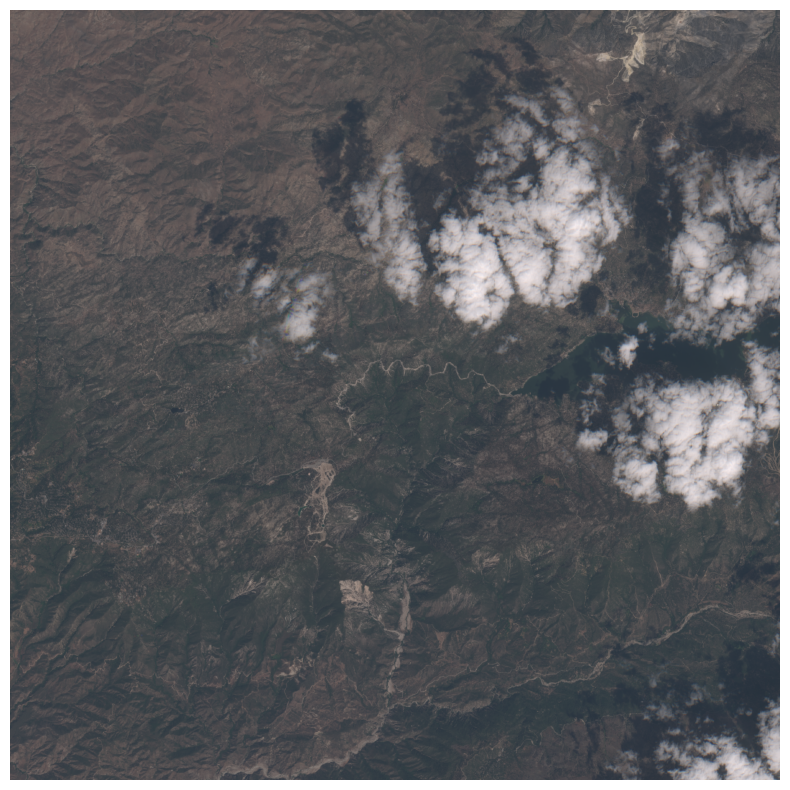

In [2]:
def stretch(band, lower=2, upper=98):
    """Realza contraste usando percentiles."""
    p_low, p_high = np.percentile(band, (lower, upper))
    return np.clip((band - p_low) / (p_high - p_low), 0, 1)

# Leer y mejorar cada banda
b2 = image[:,:,1]  # Banda azul
b3 = image[:,:,2]  # Banda verde
b4 = image[:,:,3]  # Banda roja

# Opcional: compensar bruma o bajo contraste
gamma = 2  # >1 aclara sombras y realza color
b2 = b2 ** (1/gamma)
b3 = b3 ** (1/gamma)
b4 = b4 ** (1/gamma)

# Combinar en RGB
rgb = np.dstack((b4, b3, b2))

# Mostrar
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.axis('off')
plt.show()


In [3]:
res, mask, perc = cloud_detection.is_cloudy(path_file)

Tile cloudy.npy is not cloudy (only 13.2% of pixels are cloudy).


In [4]:
# Plot mask over rgb image

plotting.create_rgb_visualization(image, os.getcwd(), job_id="test_job")

Processing RGB image: test_job


True

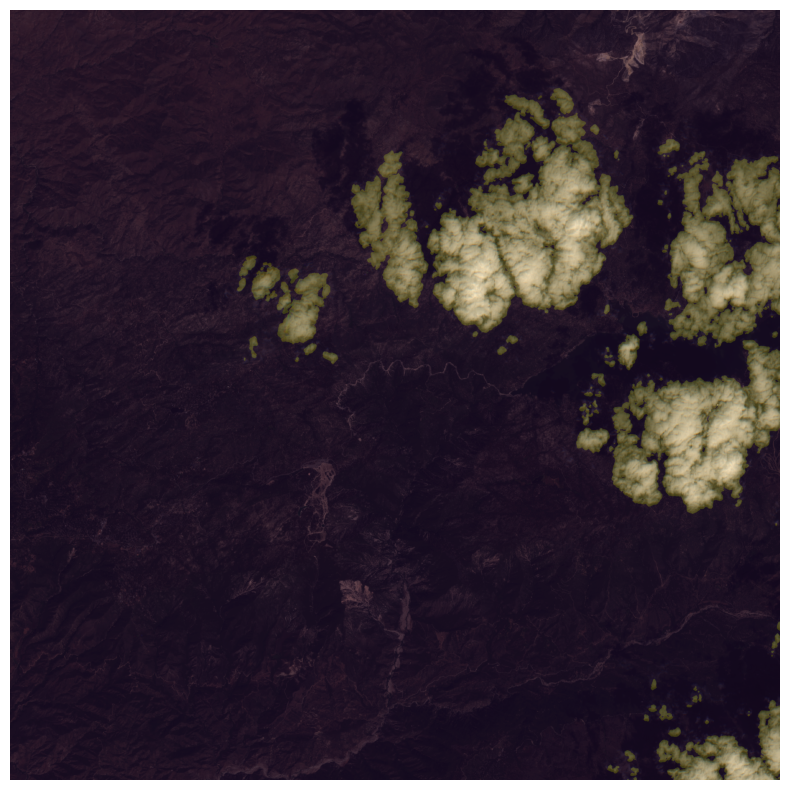

In [5]:
rgb_image_path = os.path.join(os.getcwd(), "test_job_rgb.png")

# Plot mask over rgb image

def plot_mask_on_rgb(rgb_image, mask):
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image)
    plt.imshow(mask, alpha=0.2) 
    plt.axis("off")
    plt.show()

plot_mask_on_rgb(rgb_image, mask)

In [12]:
metadata_path = "/Users/diego/Documents/FirePrediction/server/data/METADATA/82dce37e-d3d6-477f-a1bc-4033e577a651_metadata.xlsx"

In [13]:
metadata = pd.read_excel(metadata_path)
metadata

tile_number                                          tile_name  \
0             1   82dce37e-d3d6-477f-a1bc-4033e577a651_tile_(0, 0)   
1             2  82dce37e-d3d6-477f-a1bc-4033e577a651_tile_(0, ...   
2             3  82dce37e-d3d6-477f-a1bc-4033e577a651_tile_(0, ...   
3             4  82dce37e-d3d6-477f-a1bc-4033e577a651_tile_(0, ...   
4             5  82dce37e-d3d6-477f-a1bc-4033e577a651_tile_(0, ...   
..          ...                                                ...   
95           96  82dce37e-d3d6-477f-a1bc-4033e577a651_tile_(230...   
96           97  82dce37e-d3d6-477f-a1bc-4033e577a651_tile_(230...   
97           98  82dce37e-d3d6-477f-a1bc-4033e577a651_tile_(230...   
98           99  82dce37e-d3d6-477f-a1bc-4033e577a651_tile_(230...   
99          100  82dce37e-d3d6-477f-a1bc-4033e577a651_tile_(230...   

   tile_coordinates  cloud_percentage  cloud?  forest?  
0            (0, 0)          0.000000   False      NaN  
1          (0, 256)          0.000000   False      NaN  
2          (0, 512)          0.000000   False      NaN  
3          (0, 768)          0.000000   False      NaN  
4         (0, 1024)          0.000000   False      NaN  
..              ...               ...     ...      ...  
95     (2304, 1280)          0.000000   False      NaN  
96     (2304, 1536)          0.000000   False      NaN  
97     (2304, 1792)          0.049774   False      NaN  
98     (2304, 2048)          0.460358   False      NaN  
99     (2304, 2304)          0.799744    True      NaN  

[100 rows x 6 columns]

In [ ]:
def create_cloud_mask_visualization(image_data, output_folder, metadata_path, job_id=None):
    """
    Combina todos los tiles en una sola imagen grande y muestra:
    - Imagen RGB completa
    - Imagen RGB con máscara de nubes encima
    """
    try:
        print(f"Processing cloud image for: {job_id}")

        metadata = pd.read_excel(metadata_path)
        CLOUD_MASK_FOLDER = os.path.join("/Users/diego/Documents/FirePrediction/server/data", "CLOUD_IMAGES")
        TILES_IMAGES_PATH = os.path.join("/Users/diego/Documents/FirePrediction/server/data", "TILES_IMAGES")

        # --- 1. Determinar tamaño de la grilla ---
        # Suponiendo que las coordenadas son tipo "(row,col)"
        coords = [eval(c) for c in metadata['tile_coordinates']]
        rows = sorted(set(r for r, _ in coords))
        cols = sorted(set(c for _, c in coords))

        tile_dict_rgb = {}
        tile_dict_mask = {}
        tile_dict_rgb_display = {}

        # --- 2. Cargar todos los tiles ---
        for i in range(metadata.shape[0]):
            coord = eval(metadata['tile_coordinates'][i])  # (row, col)
            tile_path = os.path.join(TILES_IMAGES_PATH, f"82dce37e-d3d6-477f-a1bc-4033e577a651_tile_{metadata['tile_coordinates'][i]}.npy")
            cloud_mask_path = os.path.join(CLOUD_MASK_FOLDER, f"82dce37e-d3d6-477f-a1bc-4033e577a651_{metadata['tile_coordinates'][i]}_cloud_mask.npy")

            is_cloudy = metadata['cloud?'][i]
            perc_cloud = metadata['cloud_percentage'][i]

            tile = np.load(tile_path)

            if perc_cloud > 0.4:
                # RED tile
                rgb_tile = np.zeros_like(tile[:,:,:3])  # Create a red tile
                rgb_tile[..., 0] = 255  # Set red channel to 255
            else:
                rgb_tile = tile[:,:,[3,2,1]]  # Extract RGB bands

                # Do gamma correction
                gamma = 2  # >1 aclara sombras y realza color
                rgb_tile = np.power(rgb_tile / 255.0, gamma) * 255.0

            rgb_display = tile[:,:,[3,2,1]]  # Extract RGB bands for display
            cloud_mask = np.load(cloud_mask_path)
            
            tile_dict_rgb[coord] = rgb_tile
            tile_dict_mask[coord] = cloud_mask
            tile_dict_rgb_display[coord] = rgb_display

        # --- 3. Reconstruir la imagen grande ---
        full_rgb_rows = []
        full_mask_rows = []
        full_rgb_display_rows = []
        for r in rows:
            rgb_row = [tile_dict_rgb[(r,c)] for c in cols]
            mask_row = [tile_dict_mask[(r,c)] for c in cols]
            rgb_display_row = [tile_dict_rgb_display[(r,c)] for c in cols]
            full_rgb_rows.append(np.hstack(rgb_row))
            full_mask_rows.append(np.hstack(mask_row))
            full_rgb_display_rows.append(np.hstack(rgb_display_row))

        full_rgb = np.vstack(full_rgb_rows)
        full_mask = np.vstack(full_mask_rows)
        full_rgb_display = np.vstack(full_rgb_display_rows)

        # --- 4. Visualizar ---
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        ax[0].imshow(full_rgb)
        ax[0].set_title("Original RGB Image")
        ax[0].axis("off")

        ax[1].imshow(full_rgb_display)
        ax[1].imshow(full_mask, alpha=0.2)
        ax[1].set_title("Cloud Mask Overlay")
        ax[1].axis("off")
        plt.show()

    except Exception as e:
        print(f"  ✗ Error processing cloud mask for {job_id}: {e}")
        return False

    return True


Processing cloud image for: test_job


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


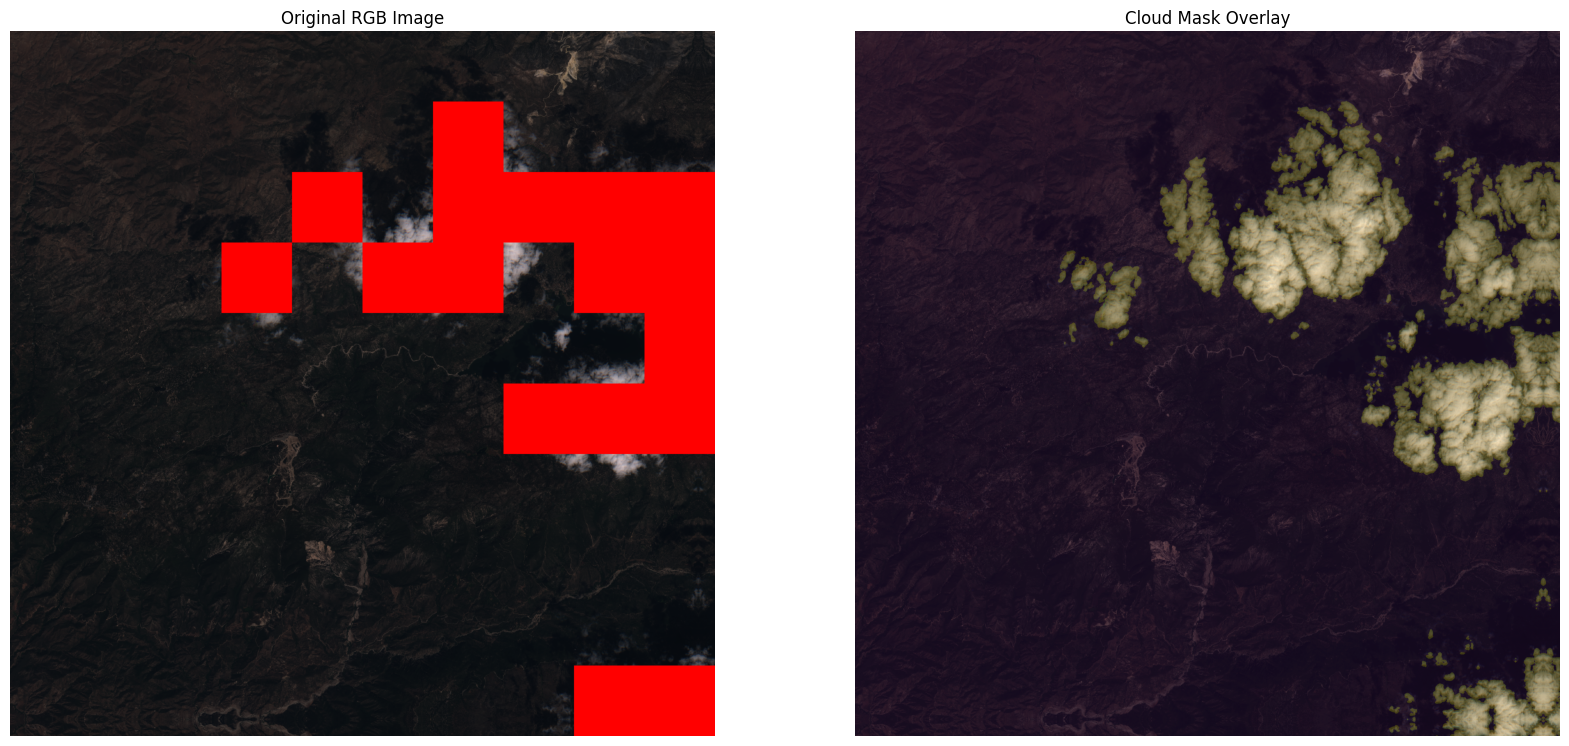

True

In [39]:
create_cloud_mask_visualization(image, os.getcwd(), metadata_path, job_id="test_job")